# SGD
$\text{params } \theta, \text{ objective } f(\theta), \text{ lr } \gamma$

$g_t = \nabla_\theta f(\theta_{t-1})$

$\theta_t = \theta_{t-1} - \gamma g_t$

# Momentum
$\text{momentum } \mu, \text{ dampening } \tau$

$g_t = \nabla_\theta f(\theta_{t-1})$

$b_t = \mu b_{t-1} + (1 - \tau) g_t$

$\theta_t = \theta_{t-1} - \gamma b_t$

Instead of updating parameters with the gradient term $g_t$, parameters are updated with the momentum term $b_t$. $b_t$ is a running sum of gradients, and can be thought of as the momentum/velocity of a ball rolling down a slope, accumulating velocity changes $g_t$. $\mu$ is how much of the old velocity is kept, and $\tau$ dampens the effect of new gradients. Momentum allows updates to potentially get much larger than individual gradients, accelerating a ball down the slope and making updates much more robust to small perturbations in the gradients.

# Nesterov Accelerated Gradient
To understand NAG, let's first write out the momentum updates for $\theta_t$ and $\theta_{t+1}$.

### Momentum update
$g_t = \nabla_\theta f(\theta_{t-1})$

$b_t = \mu b_{t-1} + (1 - \tau) g_t$

$\theta_t = \theta_{t-1} - \gamma b_t$


Regardless of the gradient term $g_{t+1}$, $\theta_t$ will be updated by the momentum term $\mu b_t$. Momentum ignores this, calculating the gradient $\nabla_\theta f(\theta_t)$ as if momentum doesn't know that $\theta_t$ will be updated to $\theta_t - \gamma \mu b_t$ no matter what.


$g_{t+1} = \nabla_\theta f(\theta_t)$

$b_{t+1} = \mu b_t + (1 - \tau) g_{t+1}$

$\theta_{t+1} = \theta_t - \gamma b_{t+1}$


### NAG update
$g_t = \nabla_\theta f(\theta_{t-1})$

$b_t = \mu b_{t-1} + (1 - \tau) g_t$

$v_t = g_t + \mu b_t$

$\theta_t = \theta_{t-1} - \gamma v_t$


NAG performs a lookahead, folding in the next momentum update $\theta_t = \theta_{t-1} - \gamma (g_t + \mu b_t)$. Then, when we calculate $g_{t+1}$, the gradient is calculated on the parameters with the inevitable momentum update already included.


$g_{t+1} = \nabla_\theta f(\theta_t)$

$b_{t+1} = \mu b_t + (1 - \tau) g_{t+1}$

$v_{t+1} = g_{t+1} + \mu b_{t+1}$

$\theta_{t+1} = \theta_{t} - \gamma v_{t+1}$


The intuition behind NAG is that in the next step, the parameters will inevitably be updated by the momentum term. In normal momentum, your next term gradient may be stale because you calculate the gradient on $\theta_t$, when the update is actually applied on $\theta_t - \gamma \mu b_t$. In NAG, you fold the next momentum step into the previous update, so that when you calculate the gradient in the next step, you calculate it on the momentum-updated parameters $\theta_t - \gamma \mu b_t$ and then apply it on the same momentum-updated parameters.

Paraphrasing from [On the importance of initialization and momentum in deep learning](https://www.cs.toronto.edu/~gdahl/papers/momentumNesterovDeepLearning.pdf), imagine a situation where a momentum update will overshoot the objective and take you from one ridge of the loss basin to the other. In normal momentum, the gradient points you down in the direction of the valley, but since your momentum update is so large, you end up overshooting the valley and end up on the other side of the valley. NAG first accounts for the fact that your momentum update will overshoot the valley, then calculates the gradient from across from where you started, again pointing you down towards the valley.

<!-- https://math.preview.excalidraw.com/#json=Y8FAlijl35WyF_GUZZ3ib,q5VgrJfKdJyLDQXLbF_M7g -->
![nag vs momentum vector diagram](images/nag.svg)

## Sources
* PyTorch docs: https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html
* On the importance of initialization and momentum in deep learning: https://www.cs.toronto.edu/~gdahl/papers/momentumNesterovDeepLearning.pdf

In [1]:
import torch

class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    @torch.no_grad()
    def zero_grad(self):
        for p in self.parameters:
            p.grad = None

class SGD(Optimizer):
    def __init__(self, parameters, lr: float = 0.001, weight_decay: float = 0, momentum: float = 0, dampening: float = 0, nesterov: bool = False):
        super().__init__(parameters)
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.dampening = dampening
        if self.momentum > 0:
            self.momentum_buffers = [None for _ in self.parameters]
        self.nesterov = nesterov
        if nesterov:
            assert self.momentum > 0, "Nesterov requires non-zero momentum."

    @torch.no_grad()
    def step(self):
        for i, p in enumerate(self.parameters):
            g = p.grad.detach().clone()
            if self.weight_decay > 0:
                g += self.weight_decay * p
            if self.momentum > 0:
                if self.momentum_buffers[i] is None:
                    self.momentum_buffers[i] = g
                else:
                    self.momentum_buffers[i] = (self.momentum * self.momentum_buffers[i]) + ((1 - self.dampening) * g)
                    if self.nesterov:
                        g += self.momentum * self.momentum_buffers[i]
                    else:
                        g = self.momentum_buffers[i]
            p -= self.lr * g

0: loss=0.430017, acc=0.898438
1: loss=0.300576, acc=0.914062


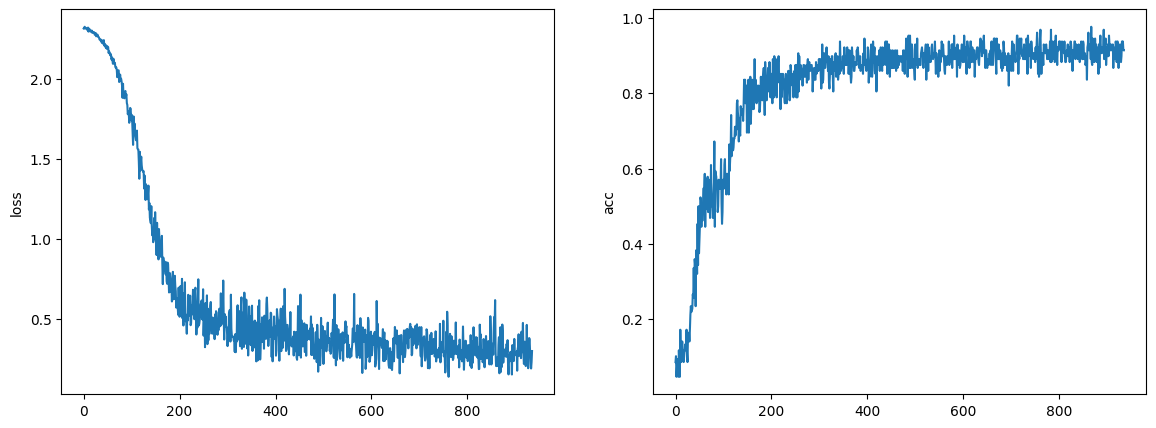

In [2]:
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2
import matplotlib.pyplot as plt

@torch.no_grad()
def calc_acc(logits: torch.Tensor, target: torch.Tensor) -> float:
    return (logits.argmax(dim=-1) == target).to(dtype=torch.float32).mean().item()

transform = v2.Compose([v2.ToImage(), v2.ToDtype(dtype=torch.float32, scale=True)])
train_ds = MNIST("data", train=True, transform=transform, download=True)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

model = nn.Sequential(nn.Flatten(), nn.Linear(784, 64), nn.ReLU(), nn.Linear(64, 10)).to("cuda")
optim = SGD(model.parameters(), lr=1e-3, weight_decay=0, momentum=0.99, nesterov=True)

losses, accs = [], []
for epoch in range(2):
    for x, y in train_dl:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())
        accs.append(calc_acc(logits, y))
    print(f"{epoch}: loss={losses[-1]:.6f}, acc={accs[-1]:.6f}")

_, (loss_ax, acc_ax) = plt.subplots(ncols=2, figsize=(14, 5))
loss_ax.plot(losses)
loss_ax.set_ylabel("loss")
acc_ax.plot(accs)
acc_ax.set_ylabel("acc")
plt.show()

# Adagrad
$\text{ sum of squared gradients } s, \text{ initial squared gradient accumulator value } \tau$

$s_0 = \tau$ <br><br>

$g_t = \nabla_\theta f(\theta_{t-1})$

$s_t = s_{t-1} + g_t^2$

$\theta_t = \theta_{t-1} - \gamma \frac{g_t}{\sqrt{s_t} + \epsilon}$

Compared to SGD, the only difference is that we normalize the gradients by the sum of the past gradients squared. With this per-parameter learning rate, Adagrad will take smaller steps for sensitive parameters with large gradients.

A problem for Adagrad is that the sum of past gradients can grow without bound, causing the effective learning rate to be far too low in later epochs and slowing down training.

PyTorch docs: https://docs.pytorch.org/docs/stable/generated/torch.optim.Adagrad.html

In [3]:
class Adagrad(Optimizer):
    def __init__(self, parameters, lr: float = 0.001, weight_decay: float = 0, init_accum_value: float = 0, eps: float = 1e-9):
        super().__init__(parameters)
        self.lr = lr
        self.weight_decay = weight_decay
        self.eps = eps
        self.sum_squared_grads = [torch.full_like(p, init_accum_value, requires_grad=False) for p in self.parameters]

    @torch.no_grad()
    def step(self):
        for i, p in enumerate(self.parameters):
            g = p.grad.detach().clone()
            if self.weight_decay > 0:
                g += self.weight_decay * p
            self.sum_squared_grads[i] += g ** 2
            p -= self.lr * (g / (self.sum_squared_grads[i].sqrt() + self.eps))

0: loss=0.768757, acc=0.851562
1: loss=0.626551, acc=0.851562


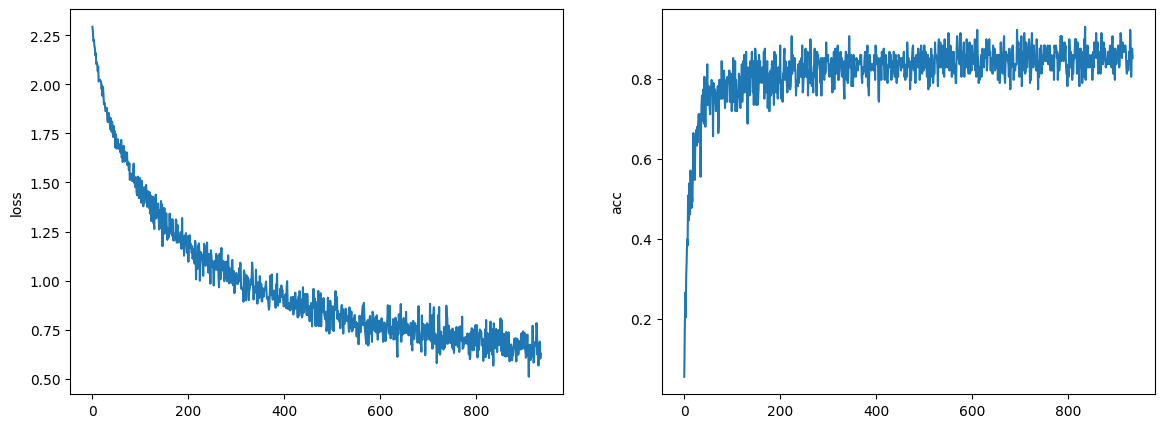

In [4]:
model = nn.Sequential(nn.Flatten(), nn.Linear(784, 64), nn.ReLU(), nn.Linear(64, 10)).to("cuda")
optim = Adagrad(model.parameters(), lr=1e-3, weight_decay=0, init_accum_value=0)

losses, accs = [], []
sum_squared_grads = []
for epoch in range(2):
    for x, y in train_dl:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())
        accs.append(calc_acc(logits, y))
        sum_squared_grads.append(torch.tensor([s.mean().item() for s in optim.sum_squared_grads]))
    print(f"{epoch}: loss={losses[-1]:.6f}, acc={accs[-1]:.6f}")

_, (loss_ax, acc_ax) = plt.subplots(ncols=2, figsize=(14, 5))
loss_ax.plot(losses)
loss_ax.set_ylabel("loss")
acc_ax.plot(accs)
acc_ax.set_ylabel("acc")
plt.show()

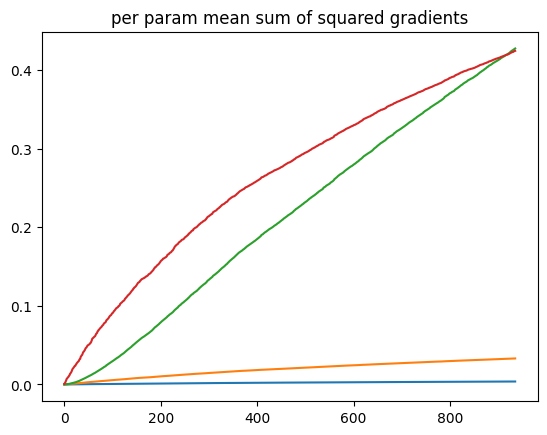

In [5]:
sum_squared_grads = torch.stack(sum_squared_grads, dim=0)
for i in range(sum_squared_grads.shape[1]):
    plt.plot(sum_squared_grads[:, i])
plt.title("per param mean sum of squared gradients")
plt.show()

# RMSProp
$g_t = \nabla_\theta f(\theta_{t-1})$

$v_t = \alpha v_{t-1} + (1-\alpha) g_t^2$

$\theta_t = \theta_{t-1} - \gamma g_t / (\sqrt{v_t} + \epsilon)$

Compared to Adagrad the only difference is that we keep a running mean of the squared gradients instead of a running sum. This fixes the problem of Adagrad's effective learning rate being too low after many steps. The intuition is the same, for sensitive parameters with large gradients, RMSProp will scale down the learning rate.

### RMSProp with Momentum
$g_t = \nabla_\theta f(\theta_{t-1})$

$v_t = \alpha v_{t-1} + (1-\alpha) g_t^2$

$b_t = \mu b_{t-1} + g_t / (\sqrt{v_t} + \epsilon)$

$\theta_t = \theta_{t-1} - \gamma b_t$

PyTorch docs: https://docs.pytorch.org/docs/stable/generated/torch.optim.RMSprop.html

In [6]:
class RMSProp(Optimizer):
    def __init__(self, parameters, lr: float = 1e-3, weight_decay: float = 0, alpha: float = 0.99, momentum: float = 0, eps: float = 1e-9):
        super().__init__(parameters)
        self.lr = lr
        self.weight_decay = weight_decay
        self.alpha = alpha
        self.eps = eps
        self.squared_grads = [torch.zeros_like(p, requires_grad=False) for p in self.parameters]
        self.momentum = momentum
        if self.momentum > 0:
            self.momentum_buffers = [torch.zeros_like(p, requires_grad=False) for p in self.parameters]

    @torch.no_grad()
    def step(self):
        for i, p in enumerate(self.parameters):
            g = p.grad.detach().clone()
            if self.weight_decay > 0:
                g += self.weight_decay * p
            self.squared_grads[i] += (1-self.alpha) * (g**2 - self.squared_grads[i])
            g /= self.squared_grads[i].sqrt() + self.eps
            if self.momentum > 0:
                self.momentum_buffers[i] = (self.momentum * self.momentum_buffers[i]) + g
                g = self.momentum_buffers[i]
            p -= self.lr * g

0: loss=0.280640, acc=0.921875
1: loss=0.094707, acc=0.960938


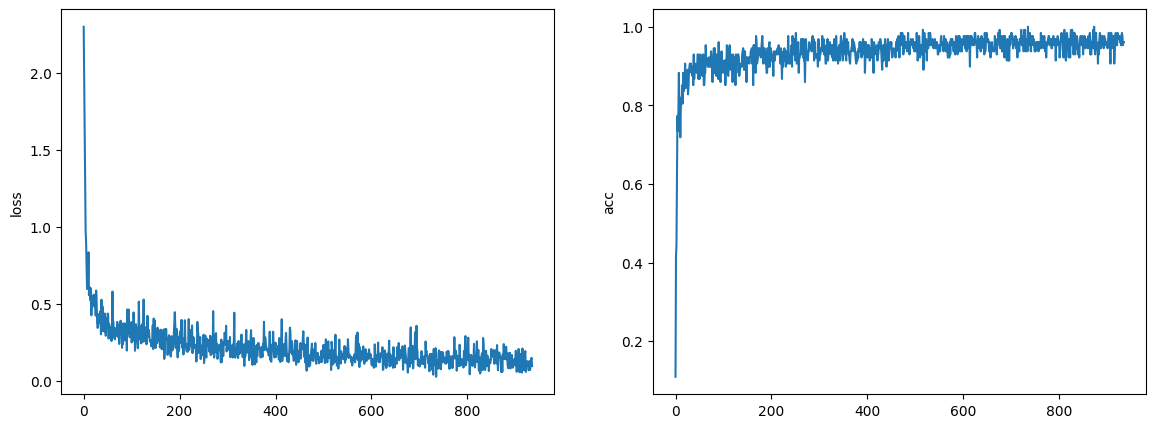

In [7]:
model = nn.Sequential(nn.Flatten(), nn.Linear(784, 64), nn.ReLU(), nn.Linear(64, 10)).to("cuda")
optim = RMSProp(model.parameters(), lr=1e-3, weight_decay=0, alpha=0.99, momentum=0.5)

losses, accs = [], []
squared_grads = []
for epoch in range(2):
    for x, y in train_dl:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())
        accs.append(calc_acc(logits, y))
        squared_grads.append(torch.tensor([s.mean().item() for s in optim.squared_grads]))
    print(f"{epoch}: loss={losses[-1]:.6f}, acc={accs[-1]:.6f}")

_, (loss_ax, acc_ax) = plt.subplots(ncols=2, figsize=(14, 5))
loss_ax.plot(losses)
loss_ax.set_ylabel("loss")
acc_ax.plot(accs)
acc_ax.set_ylabel("acc")
plt.show()

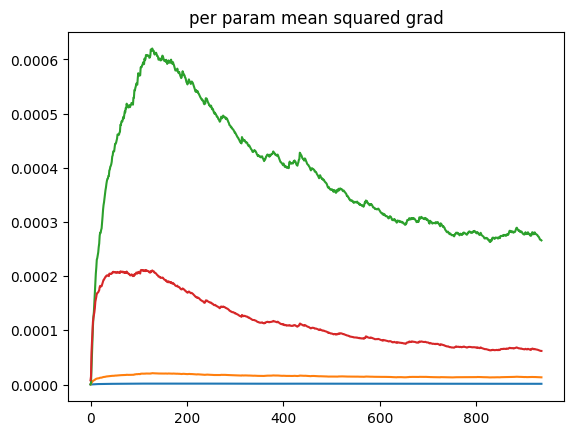

In [8]:
squared_grads = torch.stack(squared_grads, dim=0)
for i in range(squared_grads.shape[1]):
    plt.plot(squared_grads[:, i])
plt.title("per param mean squared grad")
plt.show()

# TODO
* Adam
* AdamW
* Muon

Heavy hyperparam sweeps on AdamW and Muon

Shampoo, Newton, L-BFGS